In [1]:
import numpy as np
import numpy.ma as ma

from astropy.table import QTable, Table

import sys
#sys.path.insert(1,"/Users/kellydouglass/Documents/Research/Rotation_curves/RotationCurves/spirals/")
#sys.path.insert(1, '/home/kelly/Documents/RotationCurves/spirals/')
sys.path.insert(1, "/global/homes/k/kadglass/RotationCurves/spirals/")
from DRP_rotation_curve import extract_data
from DRP_rotation_curve_plottingFunctions import plot_vel
from DRP_vel_map_functions import model_vel_map, \
                                  find_center, \
                                  find_phi, \
                                  deproject_spaxel, \
                                  find_vel_bounds, \
                                  find_sigma_bounds
from DRP_vel_map_plottingFunctions import plot_rot_curve

#from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [2]:
#MANGA_FOLDER = '/Users/kellydouglass/Documents/Research/data/SDSS/dr16/manga/spectro/'
#MANGA_FOLDER = '/home/kelly/Documents/Data/SDSS/dr16/manga/spectro/'
#MANGA_FOLDER = '/Users/kellydouglass/Documents/Research/data/SDSS/dr17/manga/spectro/'
MANGA_FOLDER = '/global/cfs/projectdirs/sdss/data/sdss/dr17/manga/spectro/'

#VEL_MAP_FOLDER = MANGA_FOLDER + 'analysis/v2_4_3/2.2.1/HYB10-GAU-MILESHC/'
VEL_MAP_FOLDER = MANGA_FOLDER + 'analysis/v3_1_1/3.1.0/HYB10-MILESHC-MASTARSSP/'

In [3]:
#fit_file = '../spirals/DRPall-master_file_30.txt'
#fit_file = '../spirals/DRP-master_file_vflag_BB_smooth1p85_mapFit_N2O2_HIdr2_noWords_v5.txt'
#fit_file = '../spirals/DRP-master_file_vflag_BB_smooth1p85_mapFit_N2O2_HIdr2_morph_v6.txt'
#fit_file = '../spirals/dr15_files/DRP-master_file_vflag_BB_smooth1p85_mapFit_N2O2_HIdr2_morph_SK_H2_noWords_v8.txt'
fit_file = '/global/homes/k/kadglass/DESI_SGA/MaNGA/dr17/master_table_Halpha_BB_HI_H2_MxCG_R90_CMD.txt'

#fit_parameters = QTable.read(fit_file, format='ascii.ecsv')
fit_parameters = Table.read(fit_file, format='ascii.commented_header')

# Sample galaxy properties

In [304]:
#gal_ID = '7443-12705'
#gal_ID = '8997-9102'
gal_ID = '9031-12705'

manga_plate, manga_IFU = gal_ID.split('-')

In [305]:
maps = extract_data(VEL_MAP_FOLDER, gal_ID, ['Ha_vel', 'Ha_flux', 'Ha_sigma', 'r_band'], dr=17)

mr_band = ma.array(maps['r_band'], mask=maps['Ha_vel_mask'])
mHa_vel = ma.array(maps['Ha_vel'], mask=maps['Ha_vel_mask'])
mHa_vel_ivar = ma.array(maps['Ha_vel_ivar'], mask=maps['Ha_vel_mask'])

mHa_sigma = ma.array(maps['Ha_sigma'], 
                     mask=maps['Ha_sigma_mask'] + maps['Ha_vel_mask'])#np.logical_or(Ha_sigma_mask > 0, Ha_vel_mask > 0))
mHa_sigma_ivar = ma.array(maps['Ha_sigma_ivar'], 
                          mask=maps['Ha_sigma_mask'] + maps['Ha_vel_mask'])

SN = maps['Ha_flux']*np.sqrt(maps['Ha_flux_ivar'])
m5Ha_vel = ma.array(maps['Ha_vel'], 
                    mask=np.logical_or(maps['Ha_vel_mask'] > 0, np.abs(SN) < 5))#0.05*np.max(np.abs(SN))))
print('5% of the maximum S/N:', 0.05*np.max(np.abs(SN)))

5% of the maximum S/N: 3.992460632324219


In [306]:
gal_fit_parameters_boolean = np.logical_and(fit_parameters['MaNGA_plate'] == int(manga_plate), 
                                            fit_parameters['MaNGA_IFU'] == int(manga_IFU))

gal_fit_parameters_row = fit_parameters[gal_fit_parameters_boolean]

gal_fit_parameters_row['chi2_map'][0]

9.624409708287155

In [307]:
H_0 = 100      # Hubble's Constant in units of h km/s/Mpc
c = 299792.458 # Speed of light in units of km/s

MANGA_FIBER_DIAMETER = 2*(1/60)*(1/60)*(np.pi/180) # angular fiber diameter (2") in radians
MANGA_SPAXEL_SIZE = 0.5*(1/60)*(1/60)*(np.pi/180)  # spaxel size (0.5") in radians


#dist_to_galaxy_Mpc = c*gal_oneD_fit_parameters_row['redshift'][0]/H_0
dist_to_galaxy_Mpc = c*gal_fit_parameters_row['NSA_redshift'][0]/H_0
dist_to_galaxy_kpc = dist_to_galaxy_Mpc*1000

pix_scale_factor = dist_to_galaxy_kpc*np.tan(MANGA_SPAXEL_SIZE)

#print(pix_scale_factor)

In [308]:
################################################################################
# Inclination angle (from photometry)
#-------------------------------------------------------------------------------
#print('ba:', gal_oneD_fit_parameters_row['NSA_ba'][0])

i_angle = np.arccos(gal_fit_parameters_row['NSA_ba'][0])

q0 = 0.2
cosi2 = (gal_fit_parameters_row['NSA_ba'][0]**2 - q0**2)/(1 - q0**2)
if cosi2 < 0:
    cosi2 = 0
i_angle2 = np.arccos(np.sqrt(cosi2))
#print('sin(i) (map fit, corrected):', np.sin(i_angle), np.sin(i_angle2))

i_angle_map_fit = np.arccos(gal_fit_parameters_row['ba_map'][0])
#print('ba from map fit:', gal_fit_parameters_row['ba_map'][0])

i_angle_map_fit_err = np.arccos(gal_fit_parameters_row['ba_err_map'][0])

print('b/a (from photometry, fit from the map):', 
      gal_fit_parameters_row['NSA_ba'][0], 
      gal_fit_parameters_row['ba_map'][0])
################################################################################


################################################################################
# Photometric center of galaxy
#-------------------------------------------------------------------------------
center = np.unravel_index(ma.argmax(mr_band), mr_band.shape)

if gal_ID == '8613-12701':
    center = (40,35)
elif gal_ID == '8134-3701':
    center = (22,22)
elif gal_ID == '9037-9102':
    center = (32, 32)

x0 = gal_fit_parameters_row['x0_map'][0]
y0 = gal_fit_parameters_row['y0_map'][0]

x0_err = gal_fit_parameters_row['x0_err_map'][0]
y0_err = gal_fit_parameters_row['y0_err_map'][0]
################################################################################


################################################################################
# Systemic velocity (velocity at galaxy's center)
#-------------------------------------------------------------------------------
v_sys = mHa_vel[center]

v_sys_map_fit = gal_fit_parameters_row['Vsys_map'][0]

v_sys_map_fit_err = gal_fit_parameters_row['Vsys_err_map'][0]
################################################################################


################################################################################
# Rotation angle (from photometry)
#-------------------------------------------------------------------------------
phi = gal_fit_parameters_row['NSA_phi'][0]#.value
#phi = 11.8158

phi_guess = find_phi(center, phi, mHa_vel)

phi_map_fit = gal_fit_parameters_row['phi_map'][0]

phi_map_fit_err = gal_fit_parameters_row['phi_err_map'][0]

print('Phi (from photometry, initial guess, fit from the map):', 
      phi, 
      phi_guess*180/np.pi, 
      phi_map_fit)
################################################################################

'''
################################################################################
# Curve used (for 1D fit)
#-------------------------------------------------------------------------------
best_rot_curve = gal_fit_parameters_row['curve_used'][0]

if best_rot_curve == -1:
    curve = 'neg'
elif best_rot_curve == 1:
    curve = 'pos'
else:
    curve = 'avg'

print(best_rot_curve, curve)
################################################################################
'''

################################################################################
# Mask used (for 2D fit)
#-------------------------------------------------------------------------------
mask_used = gal_fit_parameters_row['map_fit_flag'][0]

if mask_used == -1:
    mask = 'Original'
elif mask_used == -2:
    mask = 'Residual'
elif mask_used == -3:
    mask = 'Continuous'
elif mask_used == -4:
    mask = 'AGN'
else:
    mask = 'S/N > ' + str(mask_used)
    
print(mask_used, mask)
################################################################################


################################################################################
# Maximum velocity
#-------------------------------------------------------------------------------
# v_max = gal_fit_parameters_row[curve + '_v_max'][0]#.value

v_max_index = np.unravel_index(ma.argmax(ma.abs(mHa_vel)), mHa_vel.shape)
v_max_guess = ma.abs(mHa_vel[v_max_index]/np.sin(i_angle2))

#print(v_max_index, v_max_guess, i_angle2)

v_max_map_fit = gal_fit_parameters_row['Vmax_map'][0]

v_max_map_fit_err = gal_fit_parameters_row['Vmax_err_map'][0]
################################################################################


################################################################################
# Turn radius
#-------------------------------------------------------------------------------
# r_turn = gal_fit_parameters_row[curve + '_r_turn'][0]#.value

r_turn_guess_spaxels,_ = deproject_spaxel(v_max_index, 
                                          center, 
                                          phi_guess, 
                                          i_angle2)

#print(r_turn_guess_spaxels)

r_turn_guess = 0.5*r_turn_guess_spaxels*pix_scale_factor

if r_turn_guess < 0.01:
    r_turn_guess = 1.1*0.01
    
r_turn_map_fit = gal_fit_parameters_row['Rturn_map'][0]

r_turn_map_fit_err = gal_fit_parameters_row['Rturn_err_map'][0]
################################################################################


################################################################################
# alpha
#-------------------------------------------------------------------------------
# alpha = gal_fit_parameters_row[curve + '_alpha'][0]

alpha_guess = 2

alpha_map_fit = gal_fit_parameters_row['alpha_map'][0]

alpha_map_fit_err = gal_fit_parameters_row['alpha_err_map'][0]
################################################################################


# params = [v_sys, i_angle2, center[0], center[1], phi_guess, v_max, r_turn, alpha]
initial_guess_params = [v_sys, 
                        i_angle2, 
                        center[0], 
                        center[1], 
                        phi_guess, 
                        v_max_guess, 
                        r_turn_guess, 
                        alpha_guess]
map_fit_params = [v_sys_map_fit,
                  i_angle_map_fit,
                  x0,
                  y0,
                  phi_map_fit*np.pi/180.,
                  v_max_map_fit,
                  r_turn_map_fit,
                  alpha_map_fit]
map_fit_params_err = [v_sys_map_fit_err, 
                      i_angle_map_fit_err, 
                      x0_err, 
                      y0_err, 
                      phi_map_fit_err*np.pi/180., 
                      v_max_map_fit_err, 
                      r_turn_map_fit_err, 
                      alpha_map_fit_err]

# print('1D parameters:', params)
print('Initial guess:', initial_guess_params)
print('Fitted map:', map_fit_params)
print('Fitted map errors:', map_fit_params_err)

# best_fit_values = {'v_sys':v_sys,
#                    'ba':gal_fit_parameters_row['NSA_ba'][0],
#                    'x0':center[0],
#                    'y0':center[1],
#                    'phi':phi_guess,
#                    'r_turn':r_turn,
#                    'v_max':v_max,
#                    'alpha':alpha}
# best_fit_values_degrees = {'v_sys':v_sys,
#                            'ba':gal_fit_parameters_row['NSA_ba'][0],
#                            'x0':center[0],
#                            'y0':center[1],
#                            'phi':phi_guess,
#                            'r_turn':r_turn,
#                            'v_max':v_max,
#                            'alpha':alpha}
map_fit_params_dict = {'v_sys':map_fit_params[0], 
                       'ba': gal_fit_parameters_row['ba_map'][0],
                       'x0': map_fit_params[2], 
                       'y0': map_fit_params[3], 
                       'phi': map_fit_params[4]*180./np.pi,
                       'v_max': map_fit_params[5], 
                       'v_max_err': map_fit_params_err[5],
                       'r_turn': map_fit_params[6], 
                       'alpha': map_fit_params[7]}

b/a (from photometry, fit from the map): 0.838519 0.8930755890717574
Phi (from photometry, initial guess, fit from the map): 51.9734 51.97339999999999 21.708667556923782
0.5 S/N > 0.5
Initial guess: [-34.378986, 0.5896955554894489, 37, 37, 0.9071069534560208, 910.9176340805509, 6.519372780827126, 2]
Fitted map: [39.57617175390962, 0.46666080798906995, 38.31084165462993, 36.51396962635388, 0.3788877250891935, 302.11461048641087, 1.6116837507353448, 1.3491939701088254]
Fitted map errors: [0.17066000734444883, 1.566006157340674, 0.018518580472785588, 0.01998177407135834, 0.0010965605164301318, 6.863456675184224, 0.0443646362913887, 0.04871915002861883]


In [309]:
map_shape = mHa_vel.shape

In [310]:
# Update the Ha velocity mask to include those velocities more than 3-sigma from the mean of the 1-sigma sample
'''
stddev = ma.std(mHa_vel)
stddev2 = ma.std(mHa_vel[ma.abs(mHa_vel) <= v_sys + stddev])

m3sHa_vel = ma.array(Ha_vel, mask=np.logical_or(Ha_vel_mask > 0, 
                                                np.abs(Ha_vel) > v_sys + 3*stddev2))
'''

# Update the Ha velocity mask to exclude those velocities which are not continuous with the main velocity field
min_vel, max_vel, continuous_mask = find_vel_bounds(mHa_vel, gal_ID)

mHa_vel_continuous = ma.array(maps['Ha_vel'], mask=continuous_mask)

print(min_vel, max_vel)

-286.568603515625 293.431396484375


In [311]:
# Update the Ha velocity mask to exclude those spaxels with line widths that are not continuous with the main line width field
max_sigma, sigma_mask = find_sigma_bounds(mHa_sigma, gal_ID)

mHa_vel_nonAGN = ma.array(maps['Ha_vel'], mask=sigma_mask)

# Test `model_vel_map`

In [312]:
model_map_BB = model_vel_map(map_fit_params, #initial_guess_params,
                             map_shape, 
                             pix_scale_factor, 
                             'BB')

model_map_tanh = model_vel_map(map_fit_params[:-1], #initial_guess_params[:-1], 
                               map_shape, 
                               pix_scale_factor, 
                               'tanh')

In [313]:
plot_vel(m5Ha_vel, 
         gal_ID, 
         IMAGE_DIR='../spirals/Images/DRP/', 
         FOLDER_NAME='masked_Ha_vel/', 
         IMAGE_FORMAT='png', 
         FILENAME_SUFFIX='_Ha_vel_field.'
        )

plot_vel(ma.array(model_map_BB, mask=mHa_vel.mask), 
         gal_ID, 
         model=True, 
         IMAGE_DIR='../spirals/Images/DRP/', 
         FOLDER_NAME='fitted_velocity_fields/', 
         IMAGE_FORMAT='png',
         FILENAME_SUFFIX='_fitted_vel_field.'
         )

/tmp/ipykernel_631648/2550303672.py:59: RuntimeWarning: divide by zero encountered in log10
  chi2_BB = np.max(np.log10(maps['Ha_vel_ivar']*(model_map_BB - mHa_vel)**2))
/tmp/ipykernel_631648/2550303672.py:60: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(maps['Ha_vel_ivar']*(model_map_BB - mHa_vel)**2),


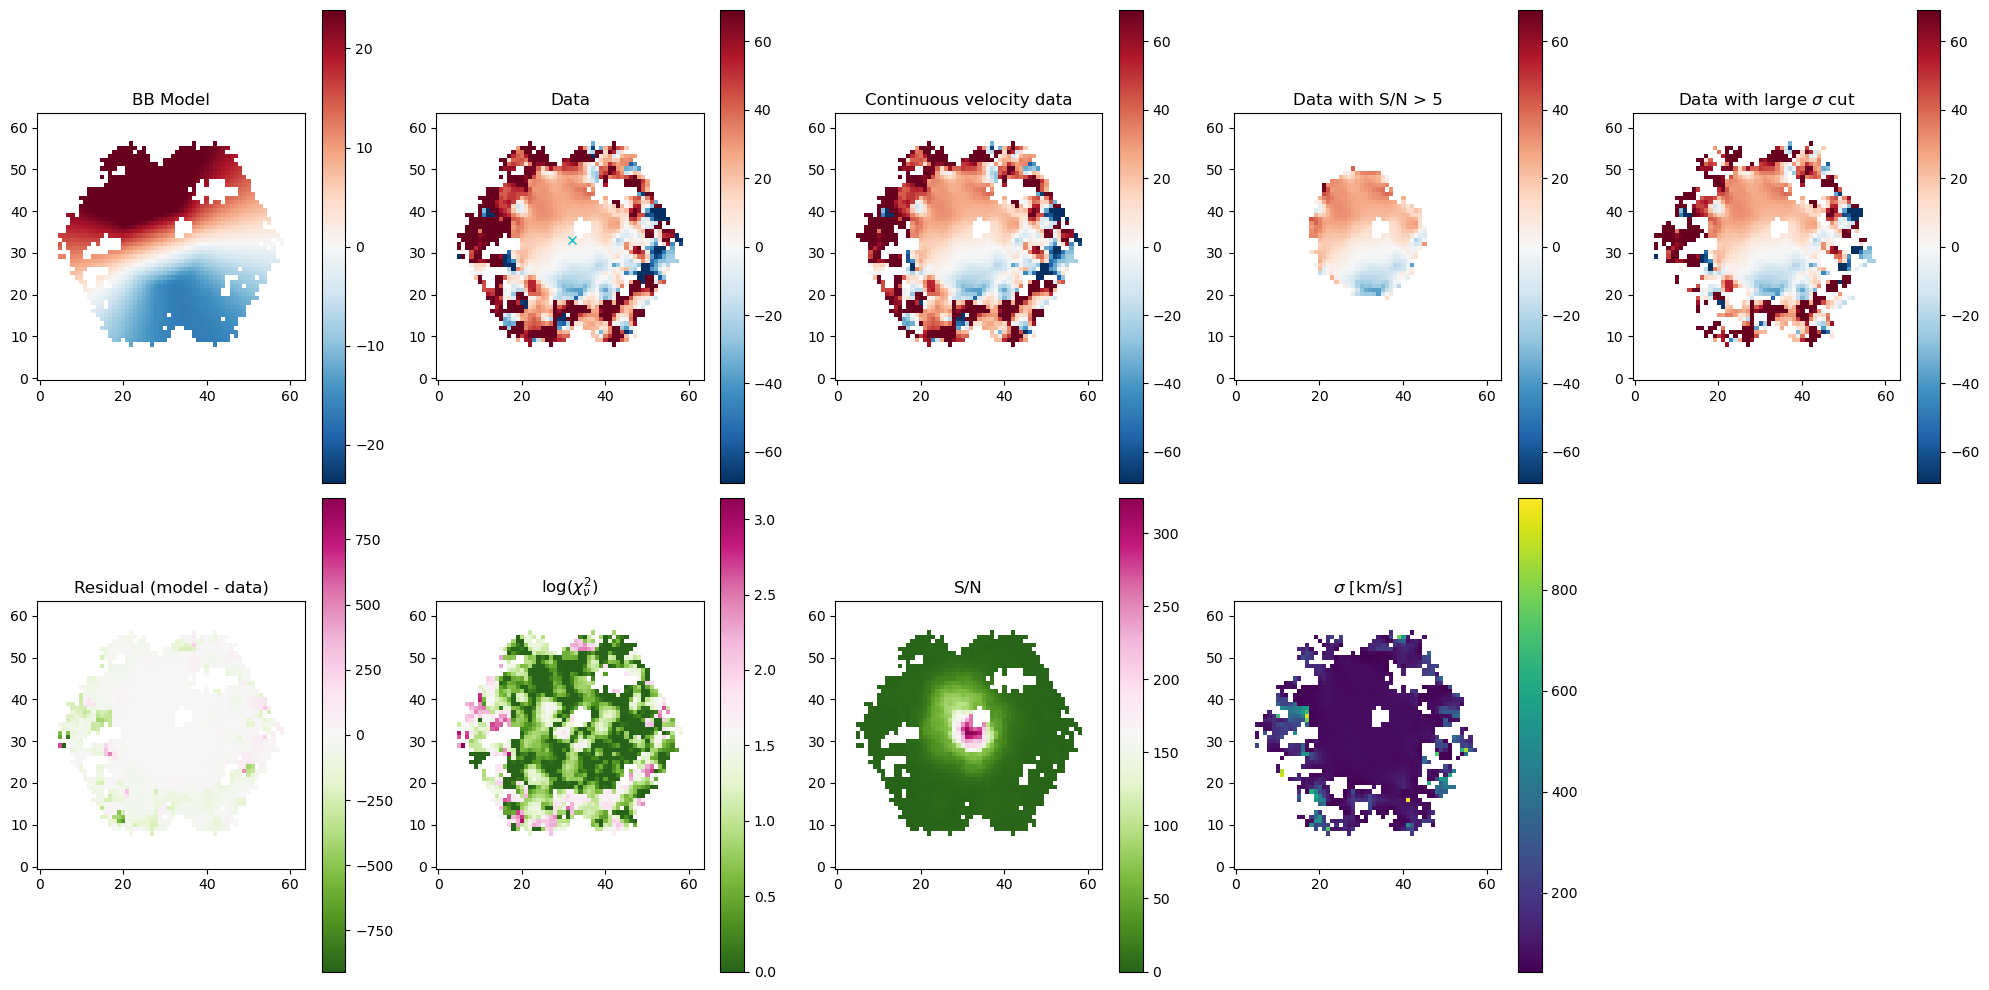

In [463]:
#extreme3 = ma.max(np.abs(mHa_vel_continuous))
extreme3 = ma.max(np.abs(m5Ha_vel))
#extreme3 = ma.max(np.abs(mHa_vel))

plt.figure(figsize=(20,10), tight_layout=True)

plt.subplot(251)
v_max_model_BB = np.max(np.abs(model_map_BB - v_sys))
#plt.imshow(ma.array(model_map_BB - v_sys, mask=mHa_vel.mask), 
plt.imshow(ma.array(model_map_BB, mask=mHa_vel.mask), 
           vmin=-v_max_model_BB, vmax=v_max_model_BB, 
           origin='lower', 
           cmap='RdBu_r')
plt.colorbar()
plt.title('BB Model')

plt.subplot(252)
plt.imshow(mHa_vel, origin='lower', cmap='RdBu_r', vmin=-extreme3, vmax=extreme3)
plt.plot(center[1], center[0], 'cx')
plt.colorbar()
plt.title('Data')

plt.subplot(253)
#plt.imshow(m3sHa_vel, origin='lower', cmap='RdBu_r', vmin=-extreme2, vmax=extreme2)
plt.imshow(mHa_vel_continuous, origin='lower', cmap='RdBu_r', vmin=-extreme3, vmax=extreme3)
plt.colorbar()
#plt.title(r'Data within 3$\sigma$')
plt.title('Continuous velocity data')

plt.subplot(254)
plt.imshow(m5Ha_vel, 
           origin='lower', 
           cmap='RdBu_r', 
           vmin=-extreme3, 
           vmax=extreme3)
plt.colorbar()
plt.title('Data with S/N > 5')

plt.subplot(255)
plt.imshow(mHa_vel_nonAGN, 
           origin='lower', 
           cmap='RdBu_r', 
           vmin=-extreme3, 
           vmax=extreme3)
plt.colorbar()
plt.title(r'Data with large $\sigma$ cut')

plt.subplot(256)
residual_BB = np.max(np.abs(model_map_BB - mHa_vel))
plt.imshow(model_map_BB - mHa_vel, 
           origin='lower', 
           cmap='PiYG_r', 
           vmin=-residual_BB, 
           vmax=residual_BB)
plt.colorbar()
plt.title('Residual (model - data)')

plt.subplot(257)
chi2_BB = np.max(np.log10(maps['Ha_vel_ivar']*(model_map_BB - mHa_vel)**2))
plt.imshow(np.log10(maps['Ha_vel_ivar']*(model_map_BB - mHa_vel)**2), 
           cmap='PiYG_r', 
           origin='lower', 
           vmin=0, 
           vmax=chi2_BB)
plt.colorbar()
plt.title(r'log($\chi^2_{\nu}$)')

plt.subplot(258)
plt.imshow(ma.array(np.abs(SN), mask=maps['Ha_vel_mask']), 
           cmap='PiYG_r', 
           origin='lower', 
           vmin=0, 
           vmax=np.max(np.abs(SN)))
plt.colorbar()
plt.title('S/N')

plt.subplot(259)
plt.imshow(mHa_sigma, origin='lower')
plt.colorbar()
plt.title('$\sigma$ [km/s]')

'''
plt.subplot(234)
#plt.imshow(model_map_tanh - v_sys, origin='lower', cmap='RdBu_r')
plt.imshow(model_map_tanh, origin='lower', cmap='RdBu_r')
plt.colorbar()
plt.title('tanh Model')

plt.subplot(235)
residual_tanh = np.max(np.abs(model_map_tanh - mHa_vel))
plt.imshow(model_map_tanh - mHa_vel, origin='lower', cmap='PiYG_r', vmin=-residual_tanh, vmax=residual_tanh)
plt.colorbar()
plt.title('Residual (model - data)')

plt.subplot(236)
plt.imshow(model_map_BB - model_map_tanh, origin='lower', cmap='RdBu_r')
plt.colorbar()
plt.title('Model difference (BB - tanh)')
''';

# Test `plot_rot_curve`

LinAlgError: Singular matrix

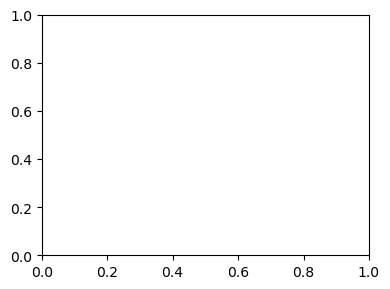

In [125]:
fig = plt.figure(figsize=(4,3), tight_layout=True)

fig.patch.set_alpha(0)

ax = fig.add_subplot(111)

#plot_rot_curve(mHa_vel, mHa_vel_ivar, best_fit_values_degrees, pix_scale_factor, gal_ID, 'BB');
#plot_rot_curve(mHa_vel, mHa_vel_ivar, map_fit_params_dict, pix_scale_factor, gal_ID, 'BB');
plot_rot_curve(m5Ha_vel, 
               mHa_vel_ivar, 
               map_fit_params_dict, 
               pix_scale_factor, 
               gal_ID, 
               'BB', 
               ax=ax, 
               HESSIAN_DIR='../spirals/');

#plt.savefig('../spirals/Images/DRP/vel_map_rot_curve_BB/7443-12705.png', dpi=120, transparent=True);

KeyError: 'v_max_err'

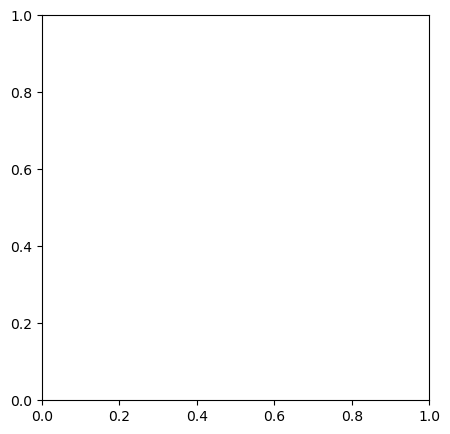

In [16]:
plot_rot_curve(mHa_vel, mHa_vel_ivar, best_fit_values_degrees, pix_scale_factor, gal_ID, 'tanh')

In [ ]:
model_map_BB_masked = ma.array(model_map_BB, mask=np.zeros(map_shape))

plot_rot_curve(model_map_BB_masked, 
               mHa_vel_ivar, 
               map_fit_params_dict, #best_fit_values_degrees, 
               pix_scale_factor, 
               gal_ID, 
               'BB');

# Test `find_center`

In [9]:
maybe_center = find_center(mHa_vel)

In [10]:
maybe_center

(43, 46)

<IPython.core.display.Javascript object>


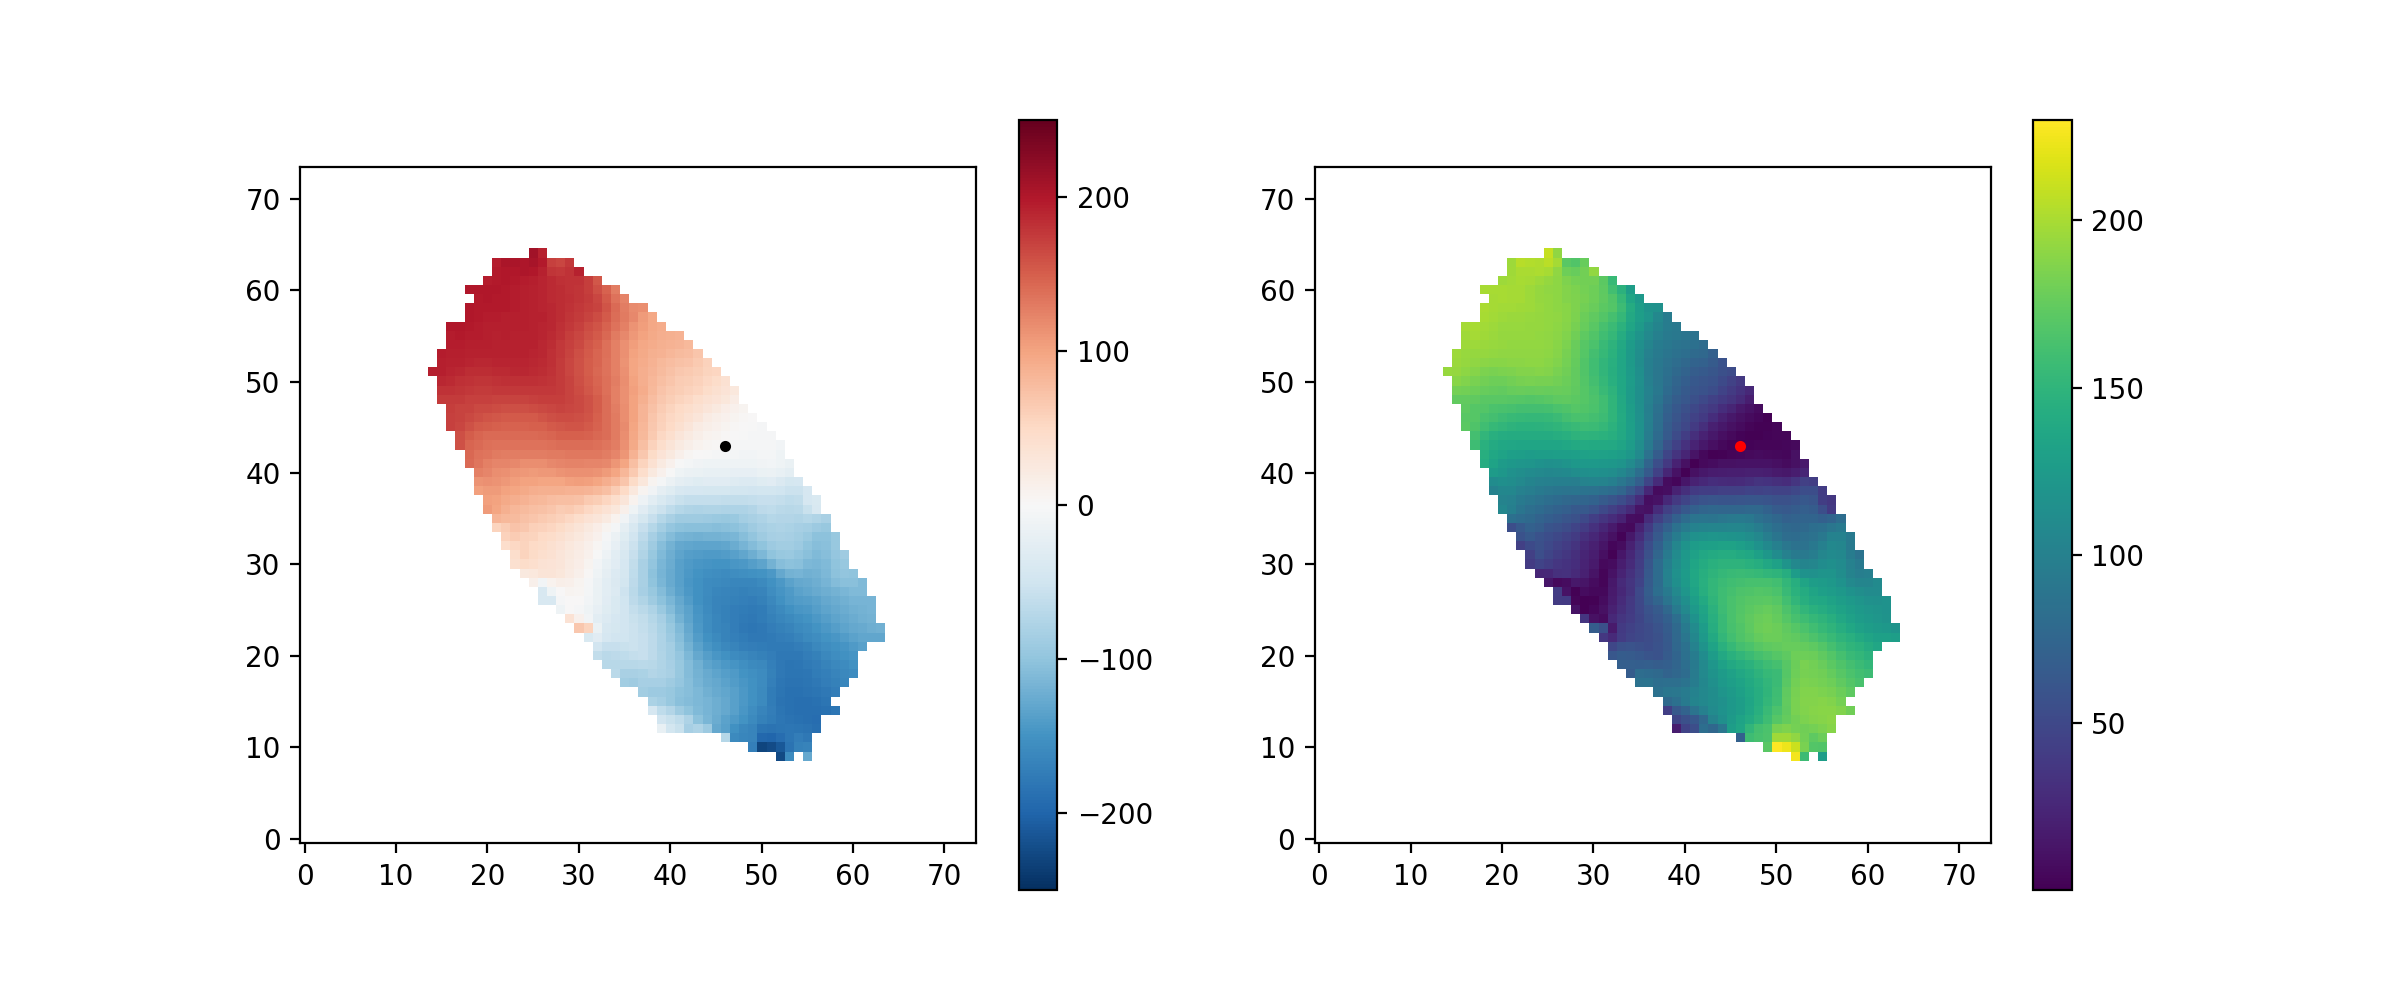

In [11]:
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.imshow(mHa_vel, origin='lower', cmap='RdBu_r', vmin=-250, vmax=250)
plt.plot(maybe_center[1], maybe_center[0], 'k.')
plt.colorbar()

plt.subplot(122)
plt.imshow(np.abs(mHa_vel), origin='lower')
plt.plot(maybe_center[1], maybe_center[0], 'r.')
plt.colorbar();

In [12]:
x = np.arange(map_shape[0])
X, Y = np.meshgrid(x,x)

<IPython.core.display.Javascript object>


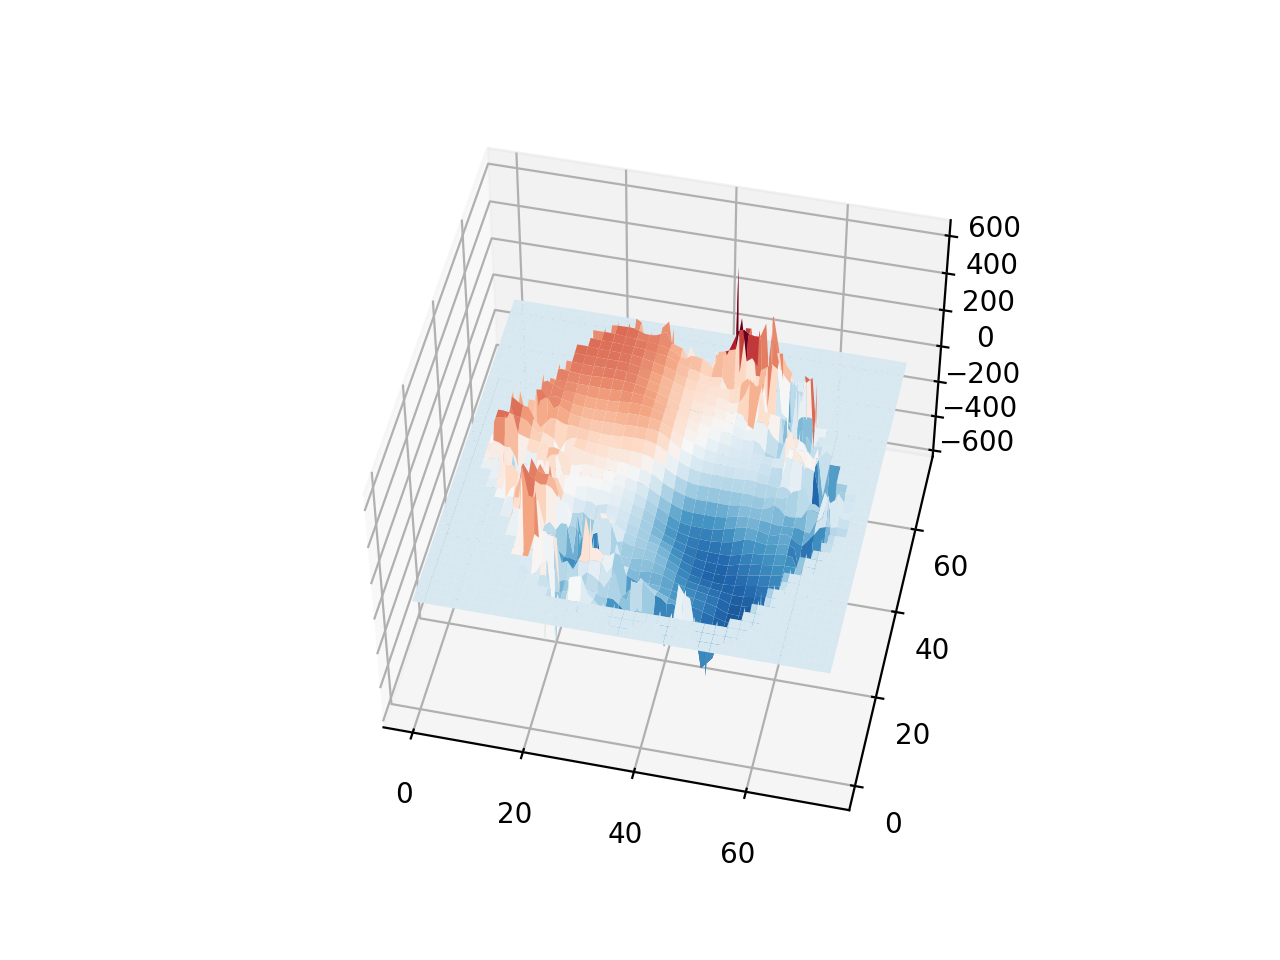

In [17]:
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot_surface(X, Y, mHa_vel, cmap='RdBu_r');
#plt.colorbar();

In [28]:
i_angle

1.0683978716829448

# Distribution in spaxel velocities

### Maybe it's possible to mask out spaxels with velocities more than some $\sigma$ from the mean?

In [235]:
stddev = ma.std(mHa_vel.flatten())

stddev2 = ma.std(mHa_vel[ma.abs(mHa_vel) <= v_sys + stddev].flatten())

print('Standard deviation:', stddev)
print('Standard deviation of shrunken sample:', stddev2)

Standard deviation: 48.812680275300586
Standard deviation of shrunken sample: 23.70157401596492


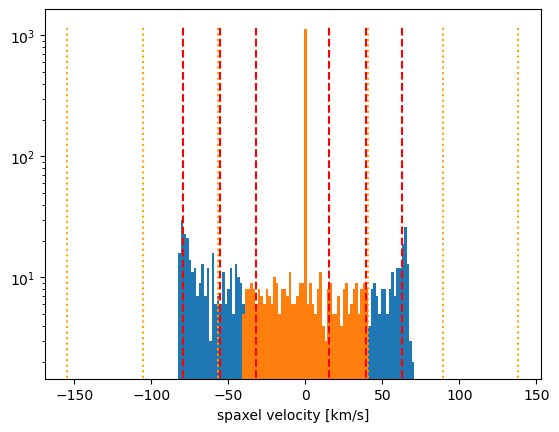

In [237]:
extreme2 = ma.max(ma.abs(mHa_vel))

plt.figure()

plt.hist(mHa_vel.flatten(), bins=np.linspace(-extreme2, extreme2, 100))
plt.hist(mHa_vel[ma.abs(mHa_vel) <= v_sys + stddev].flatten(), bins=np.linspace(-extreme2, extreme2, 100))

plt.vlines(v_sys + [stddev, 2*stddev, 3*stddev, -stddev, -2*stddev, -3*stddev], 0,1200, 
           colors='orange', linestyles=':')
plt.vlines(v_sys + [stddev2, 2*stddev2, 3*stddev2, -stddev2, -2*stddev2, -3*stddev2], 0,1200, 
           colors='red', linestyles='--')

plt.yscale('log')

plt.xlabel('spaxel velocity [km/s]');

### Instead, let's try to find the group of pixels that all go together.  Bin the data in bin widths of 50 km/s, and group all bins together which link back to the bin with the most spaxels in it.

In [123]:
bin_width = 10

extreme2 = np.max(ma.abs(mHa_vel))

vel_bin_counts, vel_bin_edges = np.histogram(mHa_vel.compressed(),#mHa_vel.flatten(), 
                                             bins=np.arange(-extreme2, extreme2 + bin_width, bin_width))

In [124]:
# Find the bin with the most counts, and build out from there

center_bin = np.argmax(vel_bin_counts)

################################################################################
# First, find the highest bin in which data is connected back to this central 
# bin
#-------------------------------------------------------------------------------
max_bin = center_bin + 1

while max_bin < len(vel_bin_counts) and vel_bin_counts[max_bin] > 0:
    max_bin += 1

max_vel = vel_bin_edges[max_bin]
################################################################################


################################################################################
# Next, find the lowest bin in which data is connected back to this central bin
#-------------------------------------------------------------------------------
if center_bin == 0:
    min_bin = 0
else:
    min_bin = center_bin - 1

while vel_bin_counts[min_bin] > 0 and min_bin > 0:
    min_bin -= 1
    
min_vel = vel_bin_edges[min_bin]
################################################################################

In [125]:
good_vel = np.logical_and(mHa_vel >= min_vel, mHa_vel <= max_vel)

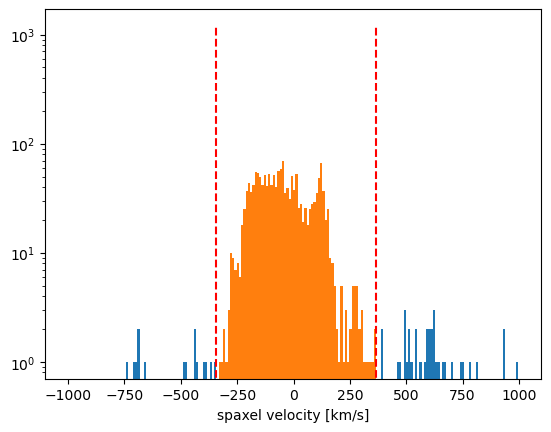

In [126]:
plt.figure()

#plt.hist(mHa_vel.flatten(), bins=np.arange(-extreme2, extreme2, bin_width))
#plt.hist(mHa_vel[good_vel].flatten(), bins=np.arange(-extreme2, extreme2, bin_width))
plt.hist(mHa_vel.compressed(), bins=np.arange(-extreme2, extreme2, bin_width))
plt.hist(mHa_vel[good_vel].compressed(), bins=np.arange(-extreme2, extreme2, bin_width))

plt.vlines([min_vel, max_vel], 0,1200, colors='red', linestyles='--')

plt.yscale('log')

plt.xlabel('spaxel velocity [km/s]');

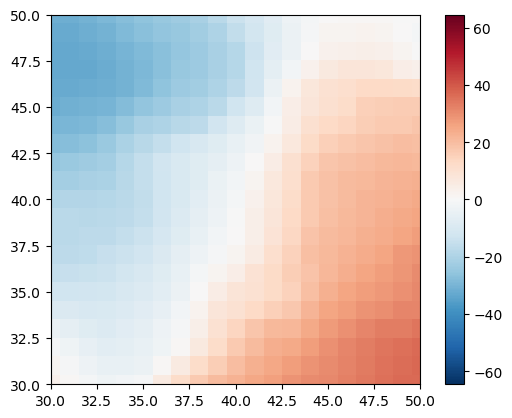

In [91]:
plt.figure()

plt.imshow(mHa_vel, origin='lower', cmap='RdBu_r', vmin=-extreme3, vmax=extreme3)

plt.xlim((30, 50))
plt.ylim((30, 50))

plt.colorbar();

# Distribution in spaxel line widths ($\sigma$)

Maybe it's possible to mask out spaxels with line widths larger than some value (to mask out AGN-like features)?

In [38]:
sigma_min = ma.min(mHa_sigma)
sigma_max = ma.max(mHa_sigma)

print(sigma_min, sigma_max)

37.911045 129.82555


<IPython.core.display.Javascript object>


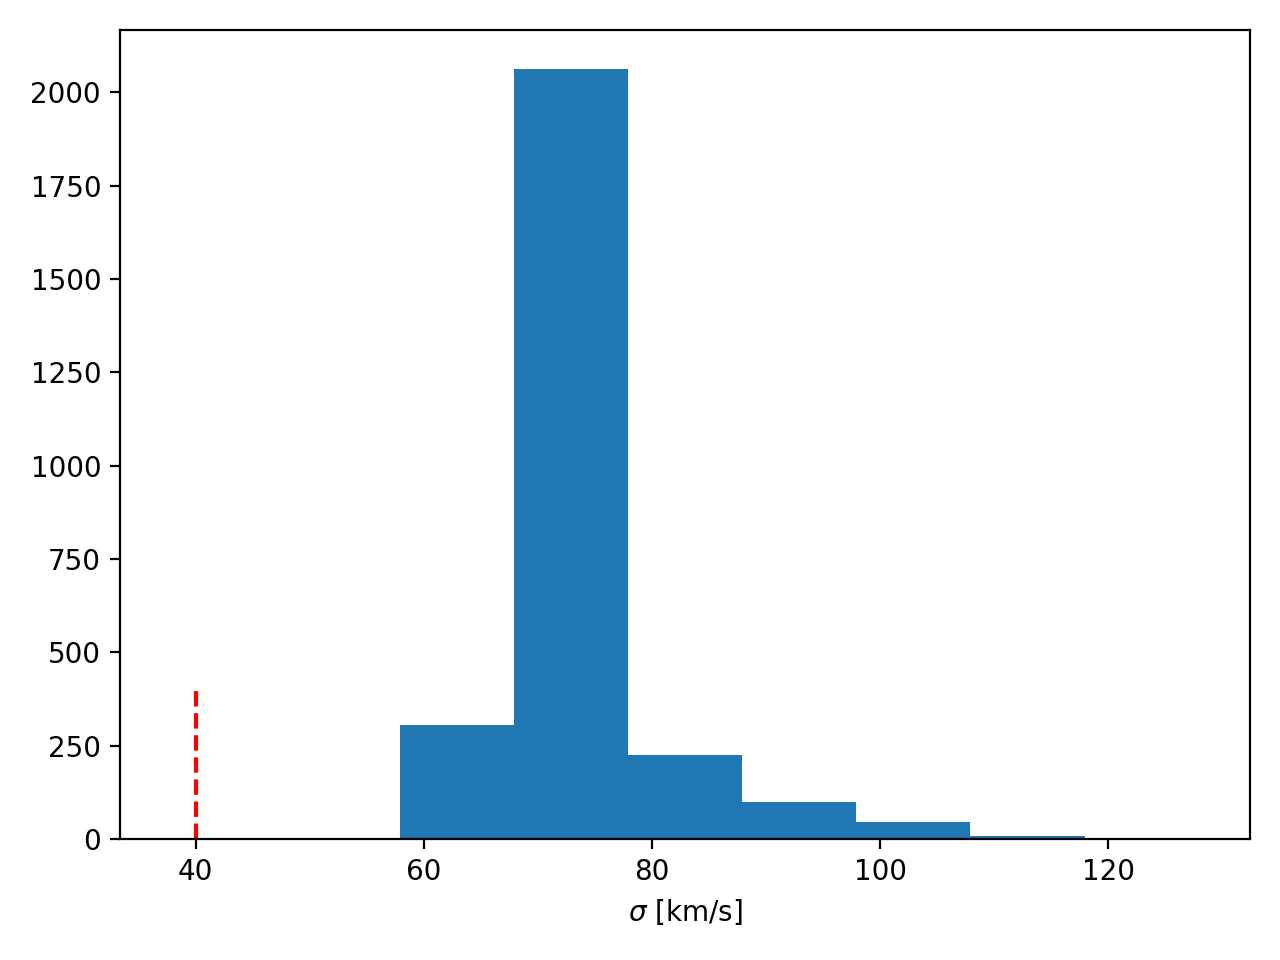

In [40]:
plt.figure()

plt.hist(mHa_sigma.compressed(), bins=np.arange(sigma_min, sigma_max, 10))
plt.vlines(max_sigma, 0,400, colors='red', linestyles='--')

plt.xlabel('$\sigma$ [km/s]')

plt.tight_layout();

# Cut based on unmasked fraction of spaxels

If there are too few spaxels left to fit, then we should not be using that fit.  So, what's the right place to cut this?

In [26]:
N_tot = mHa_vel.shape[0]*mHa_vel.shape[1]

N_normal = np.sum(~mHa_vel.mask)

N_continuous = np.sum(~mHa_vel_continuous.mask)

N_SN = np.sum(~m5Ha_vel.mask)

N_AGN = np.sum(~mHa_vel_nonAGN.mask)

In [27]:
print('Unmasked fraction of spaxels for:')
print('Normal:    ', N_normal/N_tot)
print('Continuous:', N_continuous/N_tot)
print('S/N:       ', N_SN/N_tot)
print('AGN:       ', N_AGN/N_tot)

Unmasked fraction of spaxels for:
Normal:     0.359375
Continuous: 0.244140625
S/N:        0.005859375
AGN:        0.1904296875
